In [7]:
!pip install  opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 7.4 MB/s eta 0:00:00:00:0100:01


In [9]:
## Import libraries
import os
import numpy as np
import tensorflow as tf
import scipy.io # used to convert matlab arrays to numpy ones
import h5py # used to convert matlab arrays to numpy ones
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import imageio.v3 as iio
import cv2
import pickle
import glob
import gc
#### Self defined class
os.chdir('../')
from flatband_materials_from_MP import flatband_materials_from_MP
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#### Load model and MP_path

In [15]:
#Load model
model= tf.keras.models.load_model('../flat_dataset/model.keras')

#path for input from MP
path = '../flatness_code/3_image_from_database_file/pics/'

#### Functions

In [11]:
#Function to divide the image into segments
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [23]:
# a function to plot segmented band structures
def plot_segmented_BS(rblock,cblock,model_in,predicted):
    f,ax = plt.subplots(rblock,cblock)
    plt.subplots_adjust(left=0, bottom=0, right=0.7, top=0.4, wspace=0, hspace=0.05)
    #f.tight_layout()
    for i in range(0,rblock):
        for j in range(0,cblock):   
            ax[i,j].imshow(model_in[i*cblock+j,:,:] + (predicted[i*cblock+j]*255), vmin=0, vmax=510, cmap = 'cividis')
            ax[i,j].set_yticklabels([])
            ax[i,j].set_xticklabels([])
            ax[i,j].set_yticks([])
            ax[i,j].set_xticks([])
    #plt.show()
    plt.savefig('a.png',dpi=300)

In [13]:
#finding all flat materials
def identify_all_flat(rblock,cblock,predicted,flatband_threshold):
    pred_2d=np.reshape(predicted,(rblock,cblock))
    flat_seg=[]
    for i in range(rblock):
        if all(x>=flatband_threshold for x in pred_2d[i]):
            flat_seg.append(i+1)
    if not flat_seg:
        flat_bool=False
    else:
        flat_bool=True
    return flat_seg,flat_bool

#### For large range of MP-ids in the database

In [ ]:
All_BS_files=glob.glob(path + 'mp-*')
start_at = 0 # which file to start from (counted as in the folder) # start from one lower as python list counts from 0
last_file_start_from = 70000
num_files = 2000    # How many files
for start_from in range(start_at,last_file_start_from,num_files):
    gc.collect()
    id=[]
    image_files=glob.glob(path+'mp-*')
    for i in image_files:
        id_s = i.replace('\\','.').split('.')[1]
        id.append(int(id_s.split('-')[1]))
    id.sort()
    startid = id[start_from]
    if start_from+num_files > len(All_BS_files):
        endid = id[-1]
        all_ids=id[start_from:-1]
    else:
        endid = id[start_from+num_files-1]
        all_ids=id[start_from:start_from+num_files-1]
    
    print(startid, endid)
    inputs=[]
    ids=[]
    for item in all_ids:
        try:
            x=cv2.cvtColor(cv2.imread(path+'mp-'+ str(item)+'.png'), cv2.COLOR_BGR2GRAY)
            #print(cv2.cvtColor(cv2.imread(path+'2dm-'+ str(item)+'.png'), cv2.COLOR_BGR2GRAY))
            inputs.append(x)
            ids.append(item)
        except:
            pass
            #print('no file as '+'mp-'+ str(item)+'.png')

    #%% PLOT THE INPUTS
    #fig,a = plt.subplots(1,len(ids))
    ##print(inputs[startnum:(startnum+num)])
    #for item in range(0,len(ids)):
    #    a[item].imshow(inputs[item])
    #    #print(inputs[item+startnum].shape)
    #    a[item].set_yticklabels([])
    #    a[item].set_xticklabels([])
    #plt.show()

    #%%%
    #####
    flatband_threshold=0.5
    rsize = 96
    csize = 96
    Mat_flat=[]
    model_in = np.empty((rsize,csize))
    #print(model_in)
    #print(blockshaped(inputs[0],rsize,csize).shape)
    for count,item in enumerate(inputs):
        model_in = blockshaped(item,rsize,csize)
        rblock = int(item.shape[0]/rsize)
        cblock = int(item.shape[1]/csize)
        material_id='mp-'+str(ids[count])
        #print(material_id, model_in.shape)
        predicted = model.predict(model_in, verbose = 0)
        [flat_seg,flat_bool]=identify_all_flat(rblock,cblock,predicted,flatband_threshold)
        #print('if flat band material:', flat_bool,'; Which energy segments are flat (from top):',flat_seg)
    
        ############# Uncomment following line if want to see output in figures
        #plot_segmented_BS(rblock,cblock,model_in,predicted)
        obj = flatband_materials_from_MP(material_id, rblock,cblock,predicted,flat_bool, flat_seg)
        Mat_flat.append(obj)
        if count % 100 == 0:
            print(count, material_id, model_in.shape, ' if flat band material:', flat_bool,'; Which energy segments are flat (from top):',flat_seg)
    with open('list_predicted_materials_'+str(startid)+'_'+str(endid),'wb') as ff:
        pickle.dump(Mat_flat,ff)
    del inputs, ids, Mat_flat, obj, flat_bool, flat_seg, predicted, model_in

1 2794
0 mp-1 (24, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []


#### Use only for a range of Material IDs

20 40


[ WARN:0@1825.313] global loadsave.cpp:241 findDecoder imread_('../flatness_code/3_image_from_database_file/pics/mp-22.png'): can't open/read file: check file path/integrity
[ WARN:0@1825.454] global loadsave.cpp:241 findDecoder imread_('../flatness_code/3_image_from_database_file/pics/mp-29.png'): can't open/read file: check file path/integrity
[ WARN:0@1825.476] global loadsave.cpp:241 findDecoder imread_('../flatness_code/3_image_from_database_file/pics/mp-31.png'): can't open/read file: check file path/integrity


0 mp-20 (24, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
1 mp-21 (24, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
2 mp-23 (40, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
3 mp-24 (24, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
4 mp-25 (24, 96, 96)  if flat band material: True ; Which energy segments are flat (from top): [3]
5 mp-26 (36, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
6 mp-27 (40, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
7 mp-28 (40, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
8 mp-30 (40, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
9 mp-32 (40, 96, 96)  if flat band material: False ; Which energy segments are flat (from top): []
10 mp-33 (

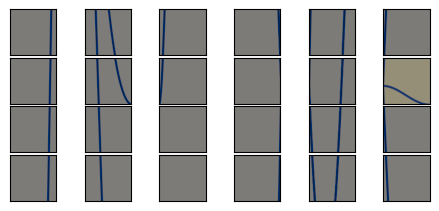

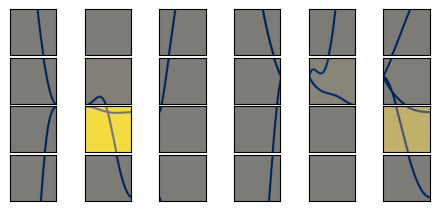

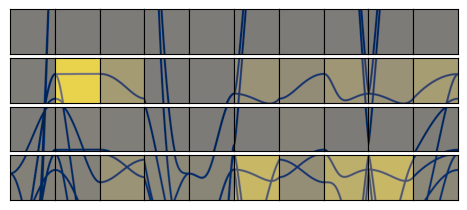

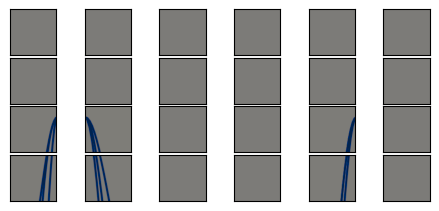

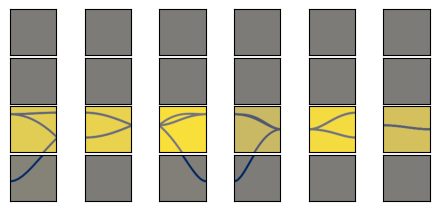

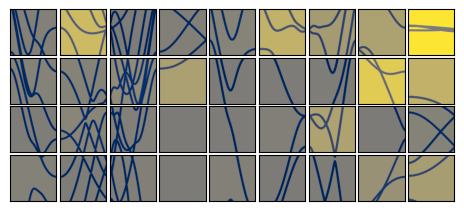

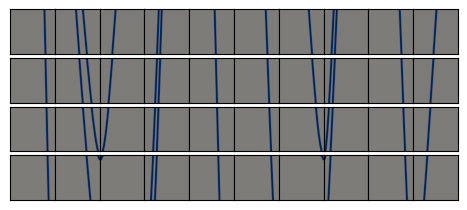

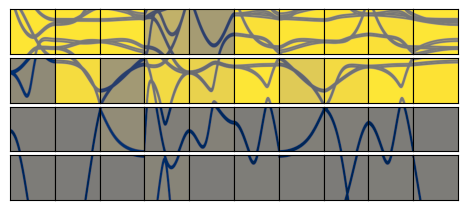

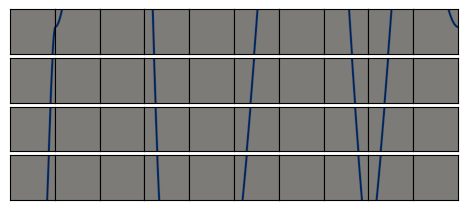

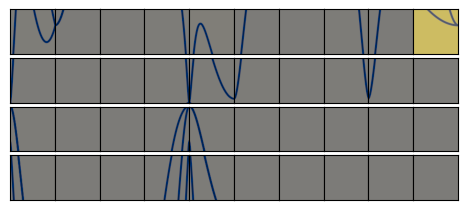

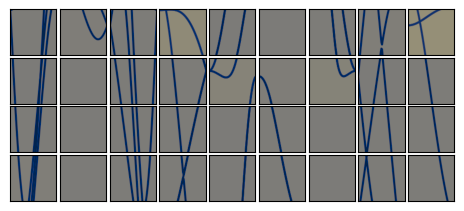

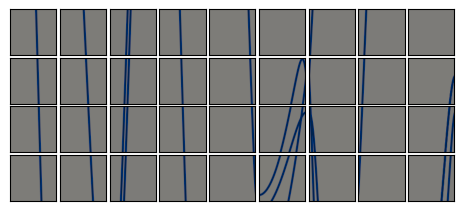

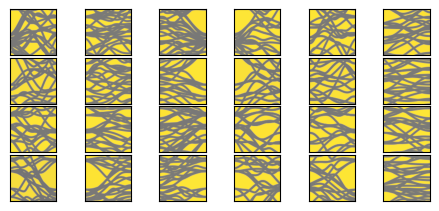

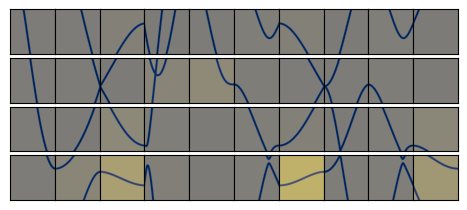

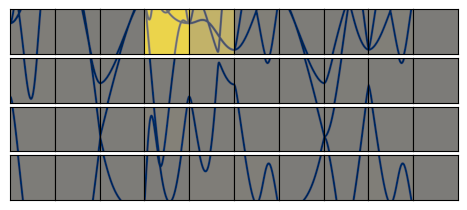

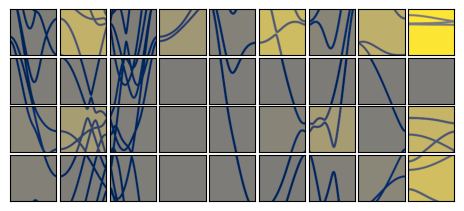

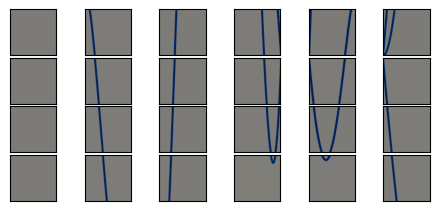

In [29]:

startid = 20
endid = 40
#    startid = id[start_from]
#    if start_from+num_files > len(All_BS_files):
#        endid = id[-1]
#        all_ids=id[start_from:-1]
#    else:
#        endid = id[start_from+num_files-1]
#        all_ids=id[start_from:start_from+num_files-1]
print(startid, endid)
inputs=[]
ids=[]
for item in range(startid,endid):
    try:
        x=cv2.cvtColor(cv2.imread(path+'mp-'+ str(item)+'.png'), cv2.COLOR_BGR2GRAY)
        #print(cv2.cvtColor(cv2.imread(path+'2dm-'+ str(item)+'.png'), cv2.COLOR_BGR2GRAY))
        inputs.append(x)
        ids.append(item)
    except:
        pass
        #print('no file as '+'mp-'+ str(item)+'.png')

#%% PLOT THE INPUTS
#fig,a = plt.subplots(1,len(ids))
##print(inputs[startnum:(startnum+num)])
#for item in range(0,len(ids)):
#    a[item].imshow(inputs[item])
#    #print(inputs[item+startnum].shape)
#    a[item].set_yticklabels([])
#    a[item].set_xticklabels([])
#plt.show()

#%%%
#####
flatband_threshold=0.5
rsize = 96
csize = 96
Mat_flat=[]
model_in = np.empty((rsize,csize))
#print(model_in)
#print(blockshaped(inputs[0],rsize,csize).shape)
for count,item in enumerate(inputs):
    model_in = blockshaped(item,rsize,csize)
    rblock = int(item.shape[0]/rsize)
    cblock = int(item.shape[1]/csize)
    material_id='mp-'+str(ids[count])
    #print(material_id, model_in.shape)
    predicted = model.predict(model_in, verbose = 0)
    [flat_seg,flat_bool]=identify_all_flat(rblock,cblock,predicted,flatband_threshold)
    #print('if flat band material:', flat_bool,'; Which energy segments are flat (from top):',flat_seg)

    ############# Uncomment following line if want to see output in figures
    plot_segmented_BS(rblock,cblock,model_in,predicted)
    obj = flatband_materials_from_MP(material_id, rblock,cblock,predicted,flat_bool, flat_seg)
    Mat_flat.append(obj)
    #if count % 100 == 0:
    print(count, material_id, model_in.shape, ' if flat band material:', flat_bool,'; Which energy segments are flat (from top):',flat_seg)
with open('list_predicted_materials_'+str(startid)+'_'+str(endid),'wb') as ff:
    pickle.dump(Mat_flat,ff)
del inputs, ids, Mat_flat, obj, flat_bool, flat_seg, predicted, model_in